In [10]:
#describe each location with companies in side
import pandas as pd
import numpy as np
import os
import pygeohash as pgh
from math import *
from sklearn.metrics.pairwise import euclidean_distances
import random
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression as LR
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from matplotlib import pylab
from sklearn.preprocessing import normalize
pjoin = os.path.join

In [2]:
#function_base
def getPosNegdat(dat):
    """
    dat: pos pair of data (location,company,geo,distance)
    return pos/neg pair of data, same structure of dat except one more column for label
    """
    shuffle_dat = dat.sample(frac=1).reset_index(drop=True)

    # shuffle_dat.head()

    twin_dat = dat.join(shuffle_dat,how='left',lsuffix='_left',rsuffix='_right')
    twin_dat = twin_dat[twin_dat['atlas_location_uuid_left'] != twin_dat['atlas_location_uuid_right']]
    print(len(twin_dat))
    twin_dat.head()

    neg_datA = twin_dat[['duns_number_left','atlas_location_uuid_right','longitude_loc_right','latitude_loc_right']]
    neg_datA = neg_datA.rename(columns={'duns_number_left':'duns_number','atlas_location_uuid_right':'atlas_location_uuid','longitude_loc_right':'longitude_loc','latitude_loc_right':'latitude_loc'})

    neg_datB = twin_dat[['duns_number_right','atlas_location_uuid_left','longitude_loc_left','latitude_loc_left']]
    neg_datB = neg_datB.rename(columns={'duns_number_right':'duns_number','atlas_location_uuid_left':'atlas_location_uuid','longitude_loc_left':'longitude_loc','latitude_loc_left':'latitude_loc'})

    neg_dat = pd.concat([neg_datA,neg_datB],axis=0)
    neg_dat['label'] = 0
    dat['label'] = 1
    res_dat = pd.concat([dat[['duns_number','atlas_location_uuid','longitude_loc','latitude_loc','label']],neg_dat],axis=0)
    print('Neg dat num:',len(neg_dat),';Pos dat num:',len(dat))
    return res_dat

def splitdat(dat,key_column=['duns_number'],right_colunm='atlas_location_uuid_tr',rate_tr=0.8):
    """
    split the <company,location> pair into training/testing dat
    """
    tr = dat.sample(frac=rate_tr)
    tt = pd.merge(dat,tr,on=key_column,how='left',suffixes=['','_tr'])
    tt = tt[tt[right_colunm].isnull()]
    tt = tt[list(tr.columns)]
    print('Train dat:', len(tr), 'Test dat:', len(tt))
    return tr,tt

#data process
def onehotdat(dat,key_column:list,dummy_na=True):
    dat[key_column] = dat[key_column].astype(str)
    dum_dat = pd.get_dummies(dat[key_column],dummy_na=dummy_na)#it has nan itself
    return dum_dat

def split2num(emp_range:str):
    max_emp_val = emp_range.replace(' ','').split('-')
    if len(max_emp_val)<2:
        return 10
    else:
        return float(max_emp_val[1])
    
def max_col(dat,col,minval=1):
    dat[col] = dat[col].apply(lambda r:max(r,minval))

def comp_dat_process(dat):
    """
    pd -> company key,cont_feature,spec_feature,dum_feature
    """
    one_hot_col_name = ['major_industry_category','location_type','primary_sic_2_digit']
    spec_col_name = 'emp_here_range'
    cont_col_name = ['emp_here','emp_total','sales_volume_us','square_footage']

    print('doing one-hot...')
    dum_dat = onehotdat(dat,one_hot_col_name)
    
    print('extract continuous...')
    cont_dat = dat[cont_col_name].fillna(value=0).astype(float)
    
    print('specific feature')
    spec_dat = dat[spec_col_name].fillna(value='1-10').astype(str)
    spec_dat = spec_dat.apply(lambda row: split2num(row))
    
    max_col(cont_dat,'emp_here',1)
    
    res_dat = dat[['duns_number']].join([cont_dat,spec_dat,dum_dat],how='left')
    assert(len(res_dat)==len(dum_dat))
    assert(len(res_dat)==len(cont_dat))
    assert(len(res_dat)==len(spec_dat))
    return res_dat

def location_dat_process(dat):
    """
    pd -> location key,cont_feature,dum_feature
    """
    one_hot_col_name = ['building_class']
    cont_col_name = ['score_predicted_eo','score_employer','num_emp_weworkcore','num_poi_weworkcore',
                     'pct_wwcore_employee','pct_wwcore_business','num_retail_stores','num_doctor_offices',
                     'num_eating_places','num_drinking_places','num_hotels','num_fitness_gyms',
                     'population_density','pct_female_population','median_age','income_per_capita',
                     'pct_masters_degree','walk_score','bike_score']

    print('doing one-hot...')
    dum_dat = onehotdat(dat,one_hot_col_name,False)
    
    print('extract continuous...')
    cont_dat = dat[cont_col_name].fillna(value=0).astype(float)
    
    res_dat = dat[['atlas_location_uuid']].join([cont_dat,dum_dat],how='left')
    assert(len(res_dat)==len(dum_dat))
    assert(len(res_dat)==len(cont_dat))
    return {'data':res_dat,
            'cont_feat_num':len(list(cont_dat.columns)),
            'dum_feat_num':len(list(dum_dat.columns))}

def comp_transpd2np(featdat,trdat,ttdat):
    tr_feat = pd.merge(trdat,featdat,on='duns_number',how='inner')
    col_list = list(tr_feat.columns)
#     print(col_list)
    trainX = tr_feat.loc[:,col_list[3:]].to_numpy()
    trainY = tr_feat[['atlas_location_uuid','longitude_loc','latitude_loc']].to_numpy()
    
    tt_feat = pd.merge(ttdat,featdat,on='duns_number',how='inner')
    col_list = list(tt_feat.columns)
#     print(col_list)
    testX = tt_feat.loc[:,col_list[3:]].to_numpy()
    testY = tt_feat[['atlas_location_uuid','longitude_loc','latitude_loc']].to_numpy()
    return trainX,trainY,testX,testY

def transpd2np(featdatC,featdatL,pairdat,cont_col_nameC,cont_col_nameL,not_feat_col):
    tr_feat = pd.merge(pairdat,featdatC,on='duns_number',how='inner')
    XCC = tr_feat.loc[:,cont_col_nameC].to_numpy()
    out_col = []
    out_col.extend(not_feat_col)
    out_col.extend(cont_col_nameC)
    dum_col_nameC = [col for col in list(tr_feat.columns) if col not in out_col]
    XDC = tr_feat.loc[:,dum_col_nameC]

    tr_feat = pd.merge(pairdat,featdatL,on='atlas_location_uuid',how='inner')
    XCL = tr_feat.loc[:,cont_col_nameL].to_numpy()
    out_col = []
    out_col.extend(not_feat_col)
    out_col.extend(cont_col_nameL)
    dum_col_nameL = [col for col in list(tr_feat.columns) if col not in out_col]
    XDL = tr_feat.loc[:,dum_col_nameL]

    Y = pairdat[['label']].to_numpy()
    return XCC,XDC,XCL,XDL,Y

def transpd2np_train_test(featdatC,featdatL,trdat,ttdat):
    not_feat_col = ['duns_number',
                     'atlas_location_uuid',
                     'longitude_loc',
                     'latitude_loc',
                     'label']
    cont_col_nameC = ['emp_here','emp_total','sales_volume_us','square_footage','emp_here_range']
    cont_col_nameL = ['score_predicted_eo','score_employer','num_emp_weworkcore','num_poi_weworkcore',
                     'pct_wwcore_employee','pct_wwcore_business','num_retail_stores','num_doctor_offices',
                     'num_eating_places','num_drinking_places','num_hotels','num_fitness_gyms',
                     'population_density','pct_female_population','median_age','income_per_capita',
                     'pct_masters_degree','walk_score','bike_score']
    trXCC,trXDC,trXCL,trXDL,trY = transpd2np(featdatC,featdatL,trdat,cont_col_nameC,cont_col_nameL,not_feat_col)
    ttXCC,ttXDC,ttXCL,ttXDL,ttY = transpd2np(featdatC,featdatL,ttdat,cont_col_nameC,cont_col_nameL,not_feat_col)
    
    trXC = np.concatenate([trXCC,trXCL],axis=1)
    trXD = np.concatenate([trXDC,trXDL],axis=1)
    ttXC = np.concatenate([ttXCC,ttXCL],axis=1)
    ttXD = np.concatenate([ttXDC,ttXDL],axis=1)
    del trXCC,trXDC,trXCL,trXDL,ttXCC,ttXDC,ttXCL,ttXDL
    return trXC,trXD,ttXC,ttXD,trY,ttY

def normalize_dat_v2(trX,ttX,axis=0):
    center = trX.mean(axis=axis)
    center = np.expand_dims(center,axis)
    scale = trX.std(axis=axis)
    scale = np.expand_dims(scale,axis)
    
    trX = (trX-center)/scale
    ttX = (ttX-center)/scale
    return trX,ttX

def get_para_normalize_dat(trX,axis=0):
    center = trX.mean(axis=axis)
    scale = trX.std(axis=axis)
    return center,scale

def apply_para_normalize_dat(X,center,scale,axis=0):
    center = np.expand_dims(center,axis)
    scale = np.expand_dims(scale,axis)
    X = (X-center)/scale
    return X

def normalize_dat(trX,ttX,cols=5,axis=0):
    D = trX[:,:cols]
    center = D.mean(axis=axis)
    center = np.expand_dims(center,axis)
    scale = D.std(axis=axis)
    scale = np.expand_dims(scale,axis)
    
    trX[:,:cols] = (D-center)/scale
    ttX[:,:cols] = (ttX[:,:cols]-center)/scale
    
def calc_topk_acc_v2(QRscore,y_truth_cat,R_cat,k=3):
    """
    QRscore: similarity score matrix shape [Q,R]
    y_truth: index(related with R) of truth label of Query
    """
    y_truth_cat = y_truth_cat.reshape(-1,1)
    max_k_preds = QRscore.argsort(axis=1)[:, -k:][:, ::-1] #得到top-k max label
    max_k_cat = R_cat[max_k_preds]
    match_array = np.logical_or.reduce(max_k_cat==y_truth_cat, axis=1) #得到匹配结果
    topk_acc_score = match_array.sum() / match_array.shape[0]
    return topk_acc_score

def calc_topk_acc_cat_all(QRscore,y_truth_cat,R_cat,k=3):
    """
    QRscore: similarity score matrix shape [Q,R]
    y_truth: index(related with R) of truth label of Query
    return top1-topk acc
    """
    res = []
    y_truth_cat = y_truth_cat.reshape(-1,1)
    max_k_preds = QRscore.argsort(axis=1)[:, -k:][:, ::-1] #得到top-k max label
    max_k_cat = R_cat[max_k_preds]
    M = max_k_cat==y_truth_cat
    for k in range(M.shape[1]):
        match_array = np.logical_or.reduce(M[:,:k+1], axis=1) #得到匹配结果
        topk_acc_score = match_array.sum() / match_array.shape[0]
        res.append(topk_acc_score)
    return res

def transpd2np_single(featdatC,featdatL,trdat):
    not_feat_col = ['duns_number',
                     'atlas_location_uuid',
                     'longitude_loc',
                     'latitude_loc',
                     'label']
    cont_col_nameC = ['emp_here','emp_total','sales_volume_us','square_footage','emp_here_range']
    cont_col_nameL = ['score_predicted_eo','score_employer','num_emp_weworkcore','num_poi_weworkcore',
                     'pct_wwcore_employee','pct_wwcore_business','num_retail_stores','num_doctor_offices',
                     'num_eating_places','num_drinking_places','num_hotels','num_fitness_gyms',
                     'population_density','pct_female_population','median_age','income_per_capita',
                     'pct_masters_degree','walk_score','bike_score']
    trXCC,trXDC,trXCL,trXDL,trY = transpd2np(featdatC,featdatL,trdat,cont_col_nameC,cont_col_nameL,not_feat_col)
    
    trXC = np.concatenate([trXCC,trXCL],axis=1)
    trXD = np.concatenate([trXDC,trXDL],axis=1)
    del trXCC,trXDC,trXCL,trXDL
    return trXC,trXD,trY

def onehot2cat(x):
    """
    x: each row is a sample
    """
    return [np.where(r==1)[0][0] for r in x]

In [33]:
datapath = '/Users/yefeichen/Database/location_recommender_system/'
cfile = ['dnb_pa.csv','dnb_sf.csv','dnb_sj.csv']
lfile = 'location_scorecard_190912.csv'
clfile = ['PA.csv','SF.csv','SJ.csv']

ind_city = 0

pdc = pd.read_csv(pjoin(datapath,cfile[ind_city]))
pdl = pd.read_csv(pjoin(datapath,lfile))
pdcl = pd.read_csv(pjoin(datapath,clfile[ind_city]))

In [ ]:
print('dummy data')
proc_pdc = comp_dat_process(pdc)
proc_pdl = location_dat_process(pdl)
print('transfer positive pair into postive and negative pair')
all_pdcl = getPosNegdat(pdcl)
print('all_train_pairs',len(all_pdcl))
print('split pair into train/test')
tr,tt = splitdat(all_pdcl,key_column=['duns_number','atlas_location_uuid'],right_colunm='label_tr',rate_tr=0.8)
print('append feature with train/test pairs')
trXC,trXD,ttXC,ttXD,trY,ttY = transpd2np_train_test(proc_pdc,proc_pdl['data'],tr,tt)

center,scale = get_para_normalize_dat(trXC)
trXC = apply_para_normalize_dat(trXC,center,scale)
ttXC = apply_para_normalize_dat(ttXC,center,scale)
# trXC,ttXC = normalize_dat_v2(trXC,ttXC)
trX = np.concatenate([trXC,trXD],axis=1)
ttX = np.concatenate([ttXC,ttXD],axis=1)

trX = normalize(trX,axis=1)
ttX = normalize(ttX,axis=1)

print('start training...')
clf = LR(random_state=0,fit_intercept=True,
         solver = 'lbfgs',
         multi_class='ovr',max_iter=1e10).fit(trX,trY)
pred_trY = clf.predict(trX)
pred_ttY = clf.predict(ttX)
test_score = clf.score(ttX,ttY)
print(test_score)

#draw verification score
score_mat = clf.predict_proba(ttX)[:,1]
precision, recall, thresholds = precision_recall_curve(ttY, score_mat)

# Draw R/P Curve
def plot_pr(auc_score, precision, recall, label=None):
    pylab.figure(num=None, figsize=(6, 5))
    pylab.xlim([0.0, 1.0])
    pylab.ylim([0.0, 1.0])
    pylab.xlabel('Recall')
    pylab.ylabel('Precision')
    pylab.title('P/R (AUC=%0.2f) / %s' % (auc_score, label))
    pylab.fill_between(recall, precision, alpha=0.5)
    pylab.grid(True, linestyle='-', color='0.75')
    pylab.plot(recall, precision, lw=1)
    pylab.show()
    
    
auc_score = auc(recall,precision)

plot_pr(auc_score, precision, recall, "pos")

fpr, tpr, roc_thresholds = roc_curve(ttY, score_mat)
roc_auc = auc(fpr,tpr)
x = list(fpr)
y = list(tpr)

plt.figure()
plt.plot(x,y)
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC-curve(AUC=%0.2f) of %s"%(roc_auc,cfile[ind_city]))

# del trXC,trXD,trX,ttXC,ttXD,ttX
# # Hell dont try if you dont have enough power service
# #topk acc
# print('doing topk acc')
# tt_unique_comp = tt.groupby(['duns_number'],as_index=False).first()[['duns_number']]
# pd_unique_location = pdcl.groupby(['atlas_location_uuid'],as_index=False).first()[['atlas_location_uuid']]
# tt_unique_comp['key'] = 0
# pd_unique_location['key'] = 0
# tt_all_pair = pd.merge(tt_unique_comp,pd_unique_location,on='key',how='outer')[['duns_number','atlas_location_uuid']]
# tt_all_pair = tt_all_pair.merge(pdcl,on=['duns_number','atlas_location_uuid'],how='left',suffixes=['_left','_right'])
# tt_all_pair = tt_all_pair[['duns_number','atlas_location_uuid','label']].fillna(0)
# print('transfer into numpy format')
# ttXC,ttXD,ttY = transpd2np_single(proc_pdc,proc_pdl['data'],tt_all_pair)
# print('normalize_dat')
# ttXC = apply_para_normalize_dat(ttXC,center,scale)
# ttX = np.concatenate([ttXC,ttXD],axis=1)
# del ttXC,ttXD
# ttX = normalize(ttX)
# print('predict...')
# score_mat = clf.predict_proba(ttX)[:,1]
# print('draw...')
# #check QR arrangement
# location_num = int(ttY.shape[0]/int(ttY.sum()))
# ttY2 = ttY.reshape(-1,location_num)
# checkmat = ttY2.sum(axis=1)
# assert((checkmat == 1).all())

# QRscore = score_mat.reshape(-1,location_num)
# ttY2_cat = np.array(onehot2cat(ttY2))
# acc = calc_topk_acc_cat_all(QRscore,ttY2_cat,np.array(list(range(location_num))),k=50)

# x = list(range(1,51))
# y = list(acc)
# # stdy = list(stdR)
# plt.figure()
# plt.plot(x,y)
# # plt.errorbar(x,y,yerr=stdy,fmt='^',mfc='yellow',mec='blue',ms=5,mew=2)

# plt.xlabel("topk")
# plt.ylabel("accuracy")
# plt.title("topk accuracy curve of "+ cfile[ind_city])
# del ttX

array([[1],
       [1],
       [1],
       ...,
       [0],
       [0],
       [0]])

In [5]:
print(pred_trY.sum(),trY.sum())
print(pred_ttY.sum(),ttY.sum(),ttY.shape[0])

20 4940
9 1279 3701


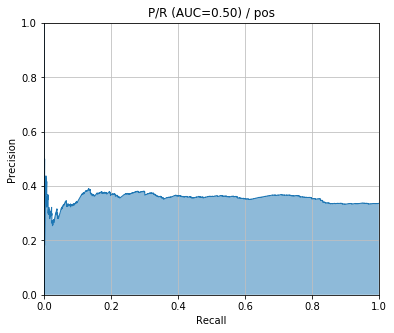

In [108]:
from sklearn.externals import joblib
joblib.dump(clf, 'lr_test.pkl') 
# clf = joblib.load('lr_test.pkl') 

['lr_test.pkl']

In [14]:
ttXC.shape,ttXD.shape,ttY.shape,trXC.shape,trXD.shape

((1072192, 24), (1072192, 1822), (1072192, 1), (14868, 24), (14868, 1822))

In [48]:
myX = np.random.random((3,4))
normX = normalize(myX,axis=1)
    

In [42]:
normX

array([[0.6743249 , 0.53806958, 0.26081202, 0.43329451],
       [0.62002619, 0.63265927, 0.03608634, 0.46260951],
       [0.42373189, 0.48254716, 0.13011018, 0.75542761]])

In [49]:
(normX**2).sum(axis=1)

array([1., 1., 1.])